In [1]:
import os
import json
import pandas as pd
import re
from collections import defaultdict
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from typing_extensions import final


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Load CSV files into DataFrames
df_initial_assesment_filtered = pd.read_csv('/content/drive/MyDrive/ER2025/Experiment2/initial_assessment_filtered.csv')
df_tasks_filtered = pd.read_csv('/content/drive/MyDrive/ER2025/Experiment2/tasks_filtered.csv')
df_final_filtered = pd.read_csv('/content/drive/MyDrive/ER2025/Experiment2/final_filtered.csv')

In [4]:
averages_by_case_experts = df_initial_assesment_filtered.groupby(['case'])[['overallCorrectness', 'Correctness.pools&Lanes','Correctness.messageFlow','Correctness.dataFlow',
                                                           'overallRelevance', 'Relevance.pools&Lanes','Relevance.messageFlow','Relevance.dataFlow',
                                                           'overallCompleteness', 'Completeness.pools&Lanes','Completeness.messageFlow','Completeness.dataFlow']].mean()



In [5]:
print("Expert Median Initial Scores")
print(df_initial_assesment_filtered[['overallCorrectness',  'overallRelevance', 'overallCompleteness']].median())

Expert Median Initial Scores
overallCorrectness     5.0
overallRelevance       6.0
overallCompleteness    6.0
dtype: float64


In [6]:
print("Expert Median Afer Scores")
print(df_tasks_filtered[['overallCorrectness',  'overallRelevance', 'overallCompleteness']].median())

Expert Median Afer Scores
overallCorrectness     6.0
overallRelevance       6.0
overallCompleteness    6.0
dtype: float64


In [7]:
def normalized_change(initial, after, min_val=0, max_val=7):
    """Return Marx & Cummings (2007) normalized change."""
    if pd.isna(initial) or pd.isna(after):
        return np.nan
    if after > initial:                       # gain
        return (after - initial) / (max_val - initial)
    elif after < initial:                     # loss
        return (after - initial) / (initial - min_val)
    else:                                     # no change
        return 0.0

In [8]:

# Rename columns to differentiate initial vs after
initial = df_initial_assesment_filtered.rename(columns={
    'overallCorrectness': 'overallCorrectness_initial',
    'overallRelevance': 'overallRelevance_initial',
    'overallCompleteness': 'overallCompleteness_initial'
})

after = df_tasks_filtered.rename(columns={
    'overallCorrectness': 'overallCorrectness_after',
    'overallRelevance': 'overallRelevance_after',
    'overallCompleteness': 'overallCompleteness_after'
})

# Merge them on case, run, sessionKey
comparison = pd.merge(
    initial[['case', 'run', 'sessionKey', 'overallCorrectness_initial', 'overallRelevance_initial', 'overallCompleteness_initial']],
    after[['case', 'run', 'sessionKey', 'overallCorrectness_after', 'overallRelevance_after', 'overallCompleteness_after']],
    on=['case', 'run', 'sessionKey'],
    how='inner'  # or 'outer' if you want all rows and handle NaNs later
)


# Step 1: Group and average initial/after metrics per (case, run, sessionKey)
metrics = ['overallCorrectness', 'overallRelevance', 'overallCompleteness']

grouped = comparison.groupby(['case', 'run', 'sessionKey']).agg({
    f'{m}_initial': 'mean' for m in metrics
} | {
    f'{m}_after': 'mean' for m in metrics
}).reset_index()

# Step 2: Apply normalized change to each metric
for m in metrics:
    grouped[f'{m}'] = grouped.apply(
        lambda row: normalized_change(row[f'{m}_initial'], row[f'{m}_after']),
        axis=1
    )

# Step 3: Aggregate gain per (case, run) for heatmap
gain_agg = grouped.groupby(['case', 'run'])[[f'{m}' for m in metrics]].mean().reset_index()

# Prepare data for heatmap
gain_agg['case_run'] = gain_agg['case'].astype(str) + '-' + gain_agg['run'].astype(str)
gain_agg.set_index('case_run', inplace=True)
gain_data = gain_agg[[f'{m}' for m in metrics]]

# --- Edit: Rename metric columns for x-axis labels ---
metric_names = {
    'overallCorrectness': 'Correctness',
    'overallRelevance': 'Relevance',
    'overallCompleteness': 'Completeness'
}
gain_data = gain_data.rename(columns=metric_names)
# -------------------------------------------------------------

# Step 4: Plot


# Step 5: Print average expert gain scores (across all sessionKeys)
print("\nAverage Expert Gain Score (per case, run, sessionKey):")
avg_expert_gain = grouped[[f'{m}' for m in metrics]].mean().round(2)
print(avg_expert_gain)





Average Expert Gain Score (per case, run, sessionKey):
overallCorrectness     0.36
overallRelevance       0.39
overallCompleteness    0.28
dtype: float64


In [9]:
# Get unique case-run pairs
unique_case_run = initial[['case', 'run', 'cluster']].drop_duplicates()
print("Number of unique (case, run, cluster):", unique_case_run.shape[0])
print("Unique (case, run, cluster):")
print(unique_case_run)

# Count occurrences of each (case, run, cluster) combination
case_run_cluster_counts = initial.groupby(['case', 'run', 'cluster']).size().reset_index(name='count')

print("Occurrences of each (case, run, cluster):")
print(case_run_cluster_counts)


Number of unique (case, run, cluster): 18
Unique (case, run, cluster):
    case  run  cluster
0      6    3        3
1      4    3        2
2      5    1        3
3      2    1        1
4      1    2        1
5      3    2        2
6      2    2        1
7      5    2        3
8      2    3        1
9      5    3        3
10     4    2        2
11     6    2        3
12     3    3        2
13     1    3        1
16     4    1        2
17     6    1        3
32     1    1        1
33     3    1        2
Occurrences of each (case, run, cluster):
    case  run  cluster  count
0      1    1        1      1
1      1    2        1      2
2      1    3        1      2
3      2    1        1      2
4      2    2        1      2
5      2    3        1      2
6      3    1        2      1
7      3    2        2      2
8      3    3        2      2
9      4    1        2      2
10     4    2        2      2
11     4    3        2      2
12     5    1        3      2
13     5    2        3      2


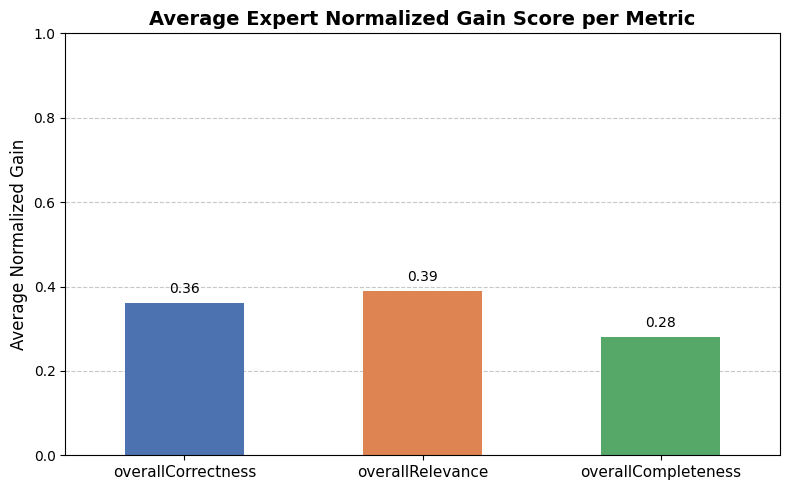

In [10]:
import matplotlib.pyplot as plt

colors = ['#4C72B0', '#DD8452', '#55A868']  # Custom clean color palette

# Create plot
fig, ax = plt.subplots(figsize=(8, 5))
bars = avg_expert_gain.plot(kind='bar', color=colors, ax=ax)

# Add value labels
for bar in bars.patches:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 5),
                textcoords='offset points',
                ha='center', va='bottom',
                fontsize=10)

# Aesthetics
ax.set_ylim(0, 1)
ax.set_ylabel("Average Normalized Gain", fontsize=12)
ax.set_title("Average Expert Normalized Gain Score per Metric", fontsize=14, weight='bold')
ax.set_xticklabels(avg_expert_gain.index, rotation=0, fontsize=11)
ax.yaxis.grid(True, linestyle='--', alpha=0.7)
ax.set_axisbelow(True)
plt.tight_layout()
plt.show()


Tool Averages after tasks
toolFeedback               3.473684
modelCheckerHelpfulness    4.058824
autoFixHelpfulness         3.200000
frustration                2.684211
dtype: float64


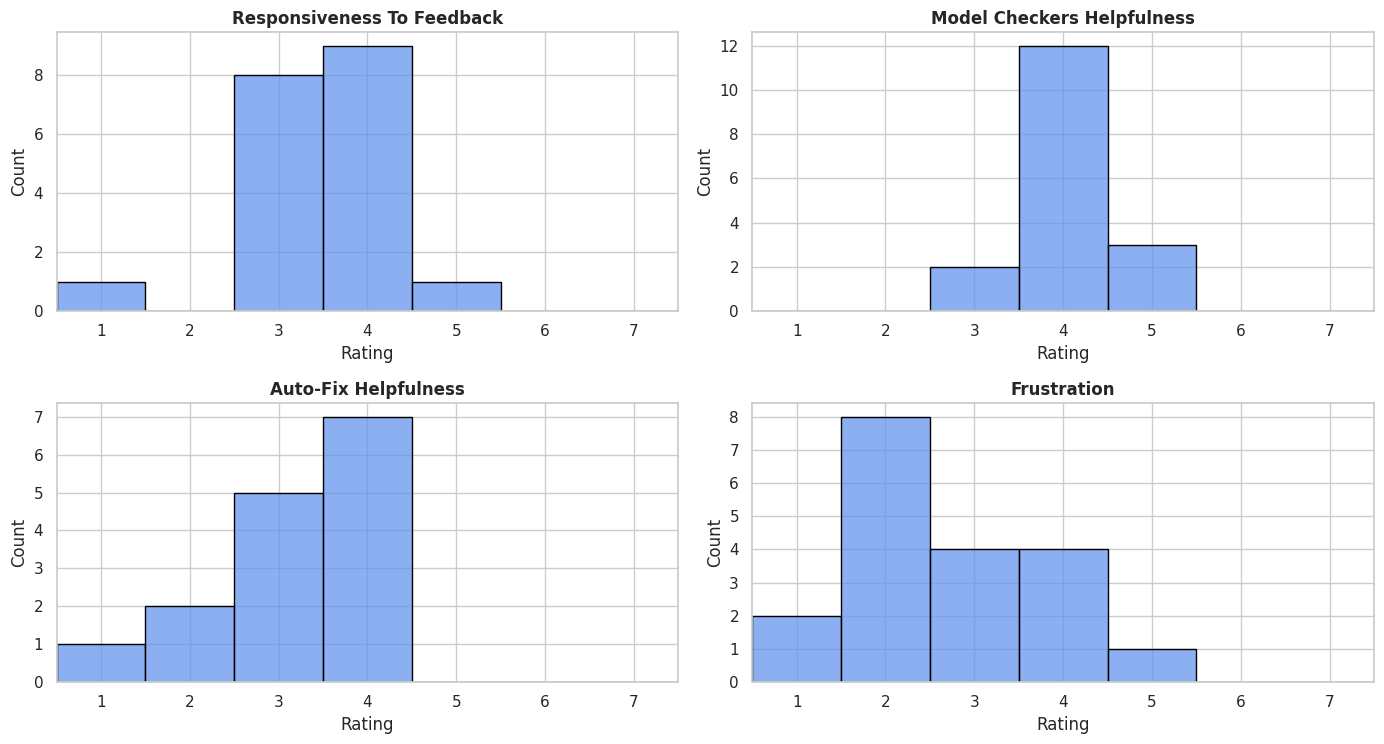

In [11]:
tool_data = df_tasks_filtered[['toolFeedback', 'modelCheckerHelpfulness', 'autoFixHelpfulness', 'frustration']]

print("Tool Averages after tasks")
print(tool_data.mean())

# Styling
sns.set(style="whitegrid")

# Plot settings
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

columns = ['toolFeedback', 'modelCheckerHelpfulness', 'autoFixHelpfulness', 'frustration']

# Plot each column
for ax, col in zip(axes.flat, columns):
    sns.histplot(tool_data[col], bins=7, binrange=(1, 7), discrete=True, kde=False, ax=ax, color="#6495ED", edgecolor="black")
    ax.set_title(col.replace("modelCheckerHelpfulness", "Model Checkers Helpfulness").replace("autoFixHelpfulness", "Auto-Fix Helpfulness").replace("toolFeedback", "Responsiveness to Feedback").title(), fontsize=12, fontweight='semibold')
    ax.set_xlim(0.5, 7.5)
    ax.set_xticks(range(1, 8))
    ax.set_xlabel("Rating")
    ax.set_ylabel("Count")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()



Final Median Ratings:
usefulness_easy: 5.00
usefulness_productivity: 5.00
usefulness_general: 6.00
intention_use: 5.00


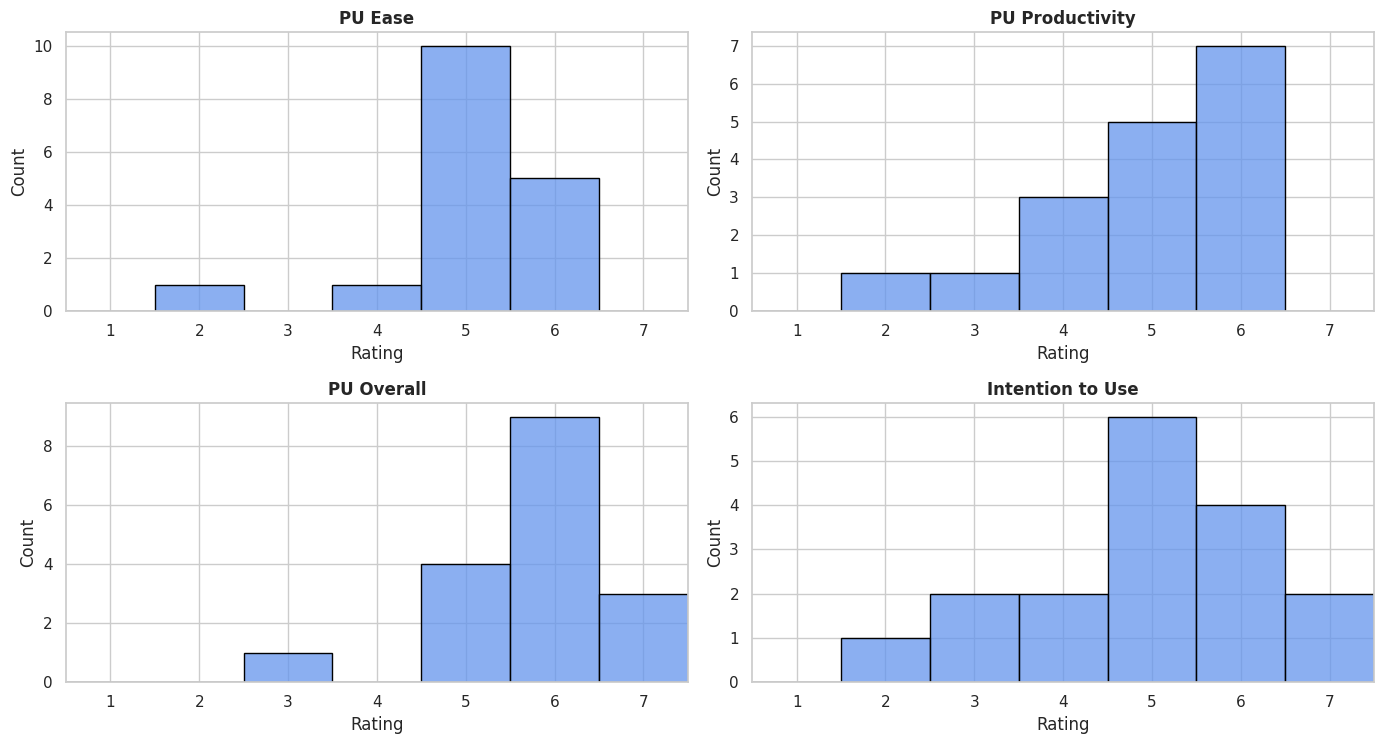

In [12]:
# Calculate and print median ratings nicely formatted
median_final = df_final_filtered[['usefulness_easy', 'usefulness_productivity', 'usefulness_general', 'intention_use']].median()
print("\nFinal Median Ratings:")
for col, avg in median_final.items():
    print(f"{col}: {avg:.2f}")

# Columns you want to visualize
final_cols = ['usefulness_easy', 'usefulness_productivity', 'usefulness_general', 'intention_use']

# Nice titles for the plots
title_map = {
    'usefulness_easy': 'PU Ease',
    'usefulness_productivity': 'PU Productivity',
    'usefulness_general': 'PU Overall',
    'intention_use': 'Intention to Use'
}

fig, axes = plt.subplots(2, 2, figsize=(14, 8))

for ax, col in zip(axes.flat, final_cols):
    # Plot histogram with discrete bins 1-7
    counts = df_final_filtered[col].value_counts().sort_index()

    sns.histplot(df_final_filtered[col], bins=7, binrange=(1, 7), discrete=True, kde=False, ax=ax, color="#6495ED", edgecolor="black")


    # Titles and labels
    ax.set_title(title_map[col], fontsize=12, fontweight='semibold')
    ax.set_xlim(0.5, 7.5)
    ax.set_xticks(range(1, 8))
    ax.set_xlabel("Rating")
    ax.set_ylabel("Count")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
